In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Parameters

In [3]:
GAMMA = 1.4 

## Solution algorithm

In [4]:
def theta_from_beta(beta, M, gamma=1.4):
    """
	Returns theta (rad) for an oblique shock.
	Accepts beta as scalar or numpy array.
    """
    beta = np.asarray(beta)                     # sûreté : cast en ndarray
    term1 = 2.0 / np.tan(beta)
    term2 = M**2 * np.sin(beta)**2 - 1.0
    term3 = M**2 * (gamma + np.cos(2.0 * beta)) + 2.0
    return np.arctan(term1 * term2 / term3)     # np.arctan !

In [5]:
def bisection(beta_low, beta_high, f, tol=1e-10, max_iter=100):
	"""Find root of f(β)=0 using bisection method (β in rad)."""
	f_low = f(beta_low)
	for _ in range(max_iter):
		beta_mid = 0.5 * (beta_low + beta_high)
		f_mid = f(beta_mid)
		if abs(f_mid) < tol:
			return beta_mid
		if f_low * f_mid < 0.0:
			beta_high = beta_mid
		else:
			beta_low, f_low = beta_mid, f_mid
	raise RuntimeError("Bisection did not converge.")

In [6]:
def bracket_roots(theta_rad, M, gamma=GAMMA, n_scan=4000):
	"""
	Scan β from Mach line to 89.9°:
	returns list of intervals [β_low, β_high] where f changes sign.
	"""
	beta_min = math.asin(1.0 / M) + 1e-6
	beta_max = math.radians(89.9)

	betas = np.linspace(beta_min, beta_max, n_scan)
	f_vals = theta_from_beta(betas, M, gamma) - theta_rad

	idx = np.where(np.diff(np.sign(f_vals)))[0]      # indices where sign changes
	return [(betas[i], betas[i + 1]) for i in idx]   # one interval → one root

In [7]:
def beta_solutions(theta_deg, M, gamma=GAMMA):
    """
    Returns a list [β_weak (rad), β_strong (rad) (optional)]
    for a given (θ, M) pair. 0 or 1 or 2 solutions.
    """
    theta_rad = math.radians(theta_deg)
    intervals = bracket_roots(theta_rad, M, gamma)
    betas = []
    for beta_low, beta_high in intervals:
        betas.append(
            bisection(beta_low, beta_high,
                      lambda b: theta_from_beta(b, M, gamma) - theta_rad))
    return betas

## Result computation

In [8]:
theta_vals  = np.linspace(0.1, 45.0, 100)
mach_list = np.linspace(1.1, 5.0, 100)

weak_beta   = np.full((mach_list.size, theta_vals.size), np.nan)
strong_beta = np.full_like(weak_beta, np.nan)

for i, M in enumerate(mach_list):
    for j, theta in enumerate(theta_vals):
        betas = beta_solutions(theta, M)      # en rad
        if not betas:                         # θ > θ_max  ⇒ on sort de la boucle θ
            break
        weak_beta[i, j] = math.degrees(betas[0])
        if len(betas) > 1:                    # solution forte disponible
            strong_beta[i, j] = math.degrees(betas[1])


In [9]:
records = []
for i, M in enumerate(mach_list):
    for j, theta in enumerate(theta_vals):
        records.append(
            dict(M=M, theta=theta,
                 beta_weak=weak_beta[i, j],
                 beta_strong=strong_beta[i, j])
        )
df = pd.DataFrame.from_records(records)
df.head()

,M,theta,beta_weak,beta_strong
0,1.1,0.100000,65.731937,89.408167
1,1.1,0.553535,67.522178,86.653281
2,1.1,1.007071,69.846596,83.519421
3,1.1,1.460606,74.127770,78.542643
4,1.1,1.914141,NaN,NaN


## Visualisation

### Heat map of betha

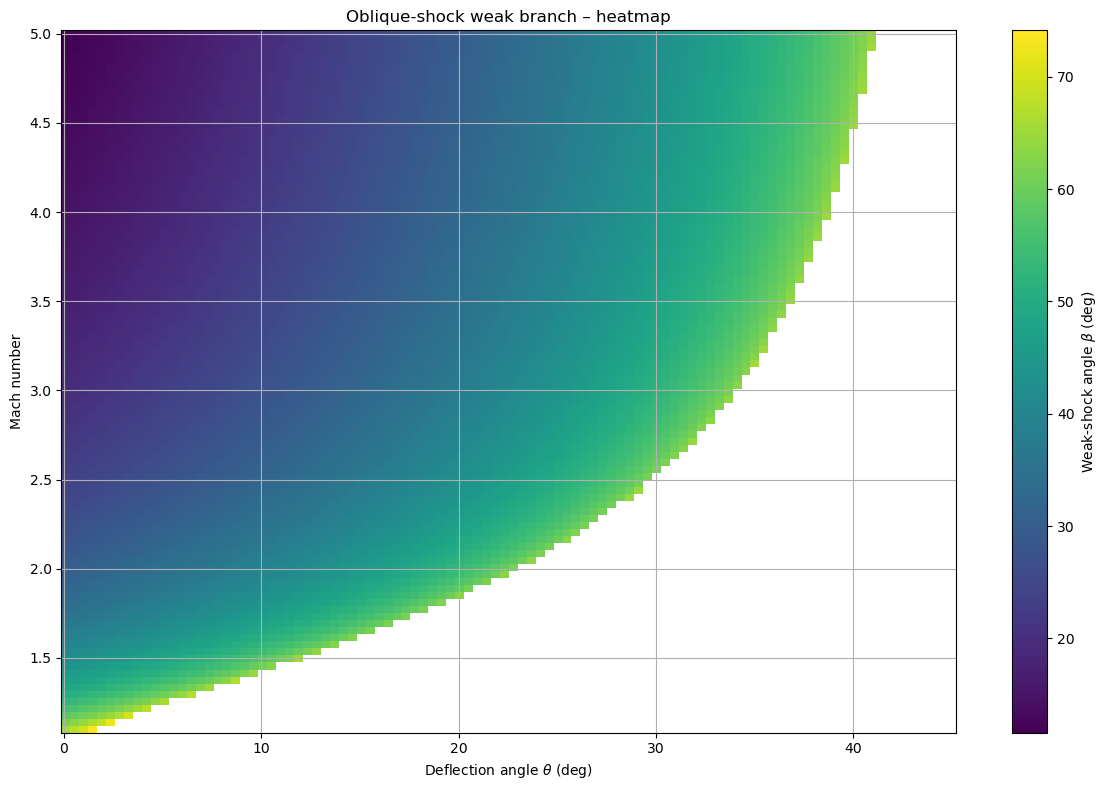

In [10]:
theta_mesh, mach_mesh = np.meshgrid(theta_vals, mach_list)

plt.figure(figsize=(12, 8))
plt.pcolormesh(theta_mesh, mach_mesh, weak_beta,      # déjà en degrés
               shading="auto", cmap="viridis")
plt.colorbar(label=r"Weak-shock angle $\beta$ (deg)")
plt.xlabel(r"Deflection angle $\theta$ (deg)")
plt.ylabel("Mach number")
plt.title("Oblique-shock weak branch – heatmap")
plt.grid(True); plt.tight_layout(); plt.show()


### Shock polar

Here the calculation is a bit diffrent so we need to compute again

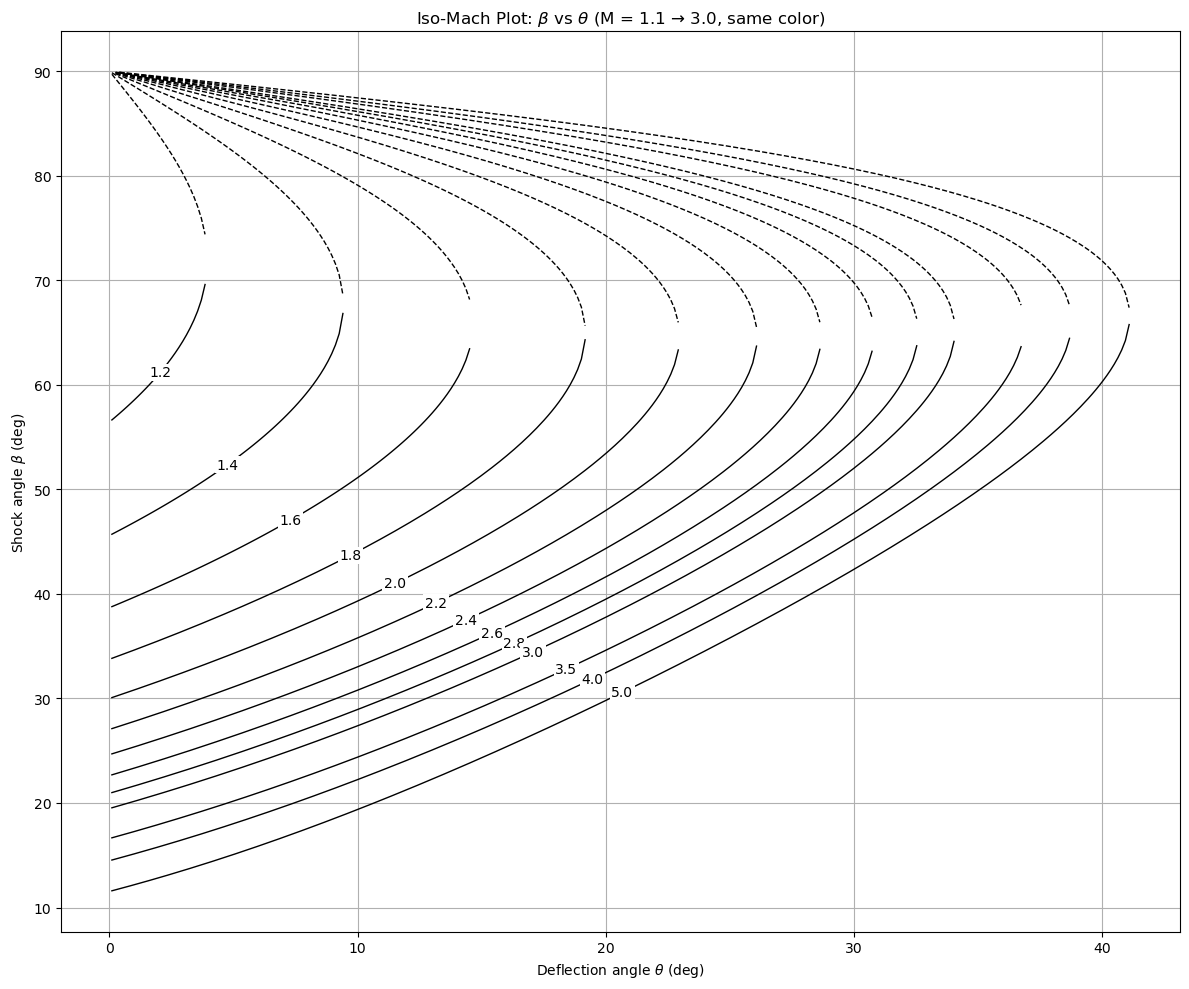

In [11]:
theta_vals = np.linspace(0.1, 45.0, 300)            # θ in degrees
mach_dense  = np.round(np.arange(1.2, 3.0, 0.2), 1) # 1.2, 1.4, …, 2.8
mach_extra  = [3.0, 3.5, 4.0, 5.0]
mach_list   = np.concatenate((mach_dense, mach_extra))

plt.figure(figsize=(12, 10))

for M in mach_list:
	weak_pts, strong_pts = [], []

	for theta in theta_vals:
		betas = beta_solutions(theta, M)            # in radians
		if not betas:
			break                                   # θ exceeds θ_max → stop

		# weak β = first root
		weak_pts.append((theta, math.degrees(betas[0])))

		# strong β = second root if it exists
		if len(betas) > 1:
			strong_pts.append((theta, math.degrees(betas[1])))

	# --- plot accumulated points --------------------------
	if weak_pts:
		t_w, b_w = zip(*weak_pts)
		plt.plot(t_w, b_w, color='black', lw=1)

		# Mach label on weak branch (middle of curve)
		mid = len(t_w) // 2
		plt.text(t_w[mid], b_w[mid], f"{M}",
				 ha="center", va="center",
				 bbox=dict(facecolor="white", edgecolor="none", pad=1.2))

	if strong_pts:
		t_s, b_s = zip(*strong_pts)
		plt.plot(t_s, b_s, color='black', lw=1, ls='--')  # dashed = strong shock

plt.xlabel(r"Deflection angle $\theta$ (deg)")
plt.ylabel(r"Shock angle $\beta$ (deg)")
plt.title(r"Iso-Mach Plot: $\beta$ vs $\theta$ (M = 1.1 → 3.0, same color)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Linear comparaison

In [13]:
# Select the desired theta values
theta_values = [0, 5, 10, 15, 20]

# Create a filtered DataFrame for each theta value (with some tolerance due to floating point)
filtered_dfs = []
tolerance = 0.1  # tolerance of ±0.1 degrees

for theta in theta_values:
	mask = (df['theta'] >= theta - tolerance) & (df['theta'] <= theta + tolerance)
	filtered_df = df[mask].copy()
	filtered_df = filtered_df.sort_values('M')  # Sort by Mach number
	filtered_dfs.append(filtered_df)
 
filtered_df.head()  # Display the first few rows of the filtered DataFrame

,M,theta,beta_weak,beta_strong
44,1.100000,20.055556,NaN,NaN
144,1.139394,20.055556,NaN,NaN
244,1.178788,20.055556,NaN,NaN
344,1.218182,20.055556,NaN,NaN
444,1.257576,20.055556,NaN,NaN


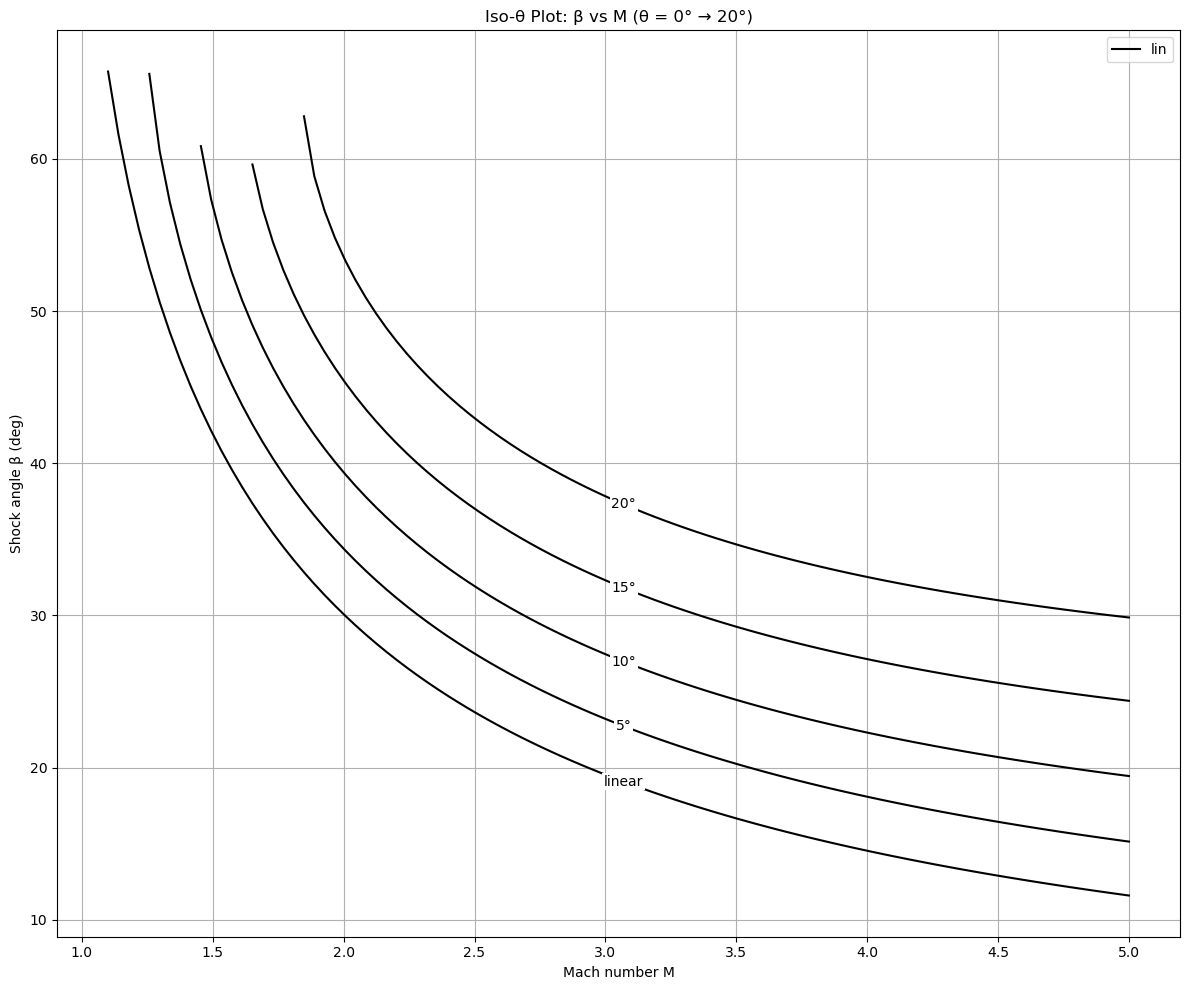

In [21]:
plt.figure(figsize=(12, 10))

# Plot for each theta value
for theta in theta_values:
	# Filter data for this theta value (with tolerance)
	mask = (df['theta'] >= theta - tolerance) & (df['theta'] <= theta + tolerance)
	data = df[mask].sort_values('M')
	
	# Plot only weak solutions
	plt.plot(data['M'], data['beta_weak'], 'black', 
			 label='lin' if theta == theta_values[0] else None)
	
	# Add theta label in the middle of the weak branch
	mid = len(data) // 2
	if not data.empty:
		if theta == 0:
			tag = "linear"
		else:
			tag = f"{theta}°"
		plt.text(data['M'].iloc[mid], data['beta_weak'].iloc[mid], tag,
				ha='center', va='center',
				bbox=dict(facecolor='white', edgecolor='none', pad=1.2))

plt.xlabel('Mach number M')
plt.ylabel('Shock angle β (deg)')
plt.title('Iso-θ Plot: β vs M (θ = 0° → 20°)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

First few rows of error analysis:
      theta  absolute_error  relative_error
0  0.100000        0.000000        0.000000
1  0.250167        0.378543        1.710750
2  0.400334        0.771626        3.464912
3  0.550502        1.194976        5.286732
4  0.700669        1.520634        7.029210


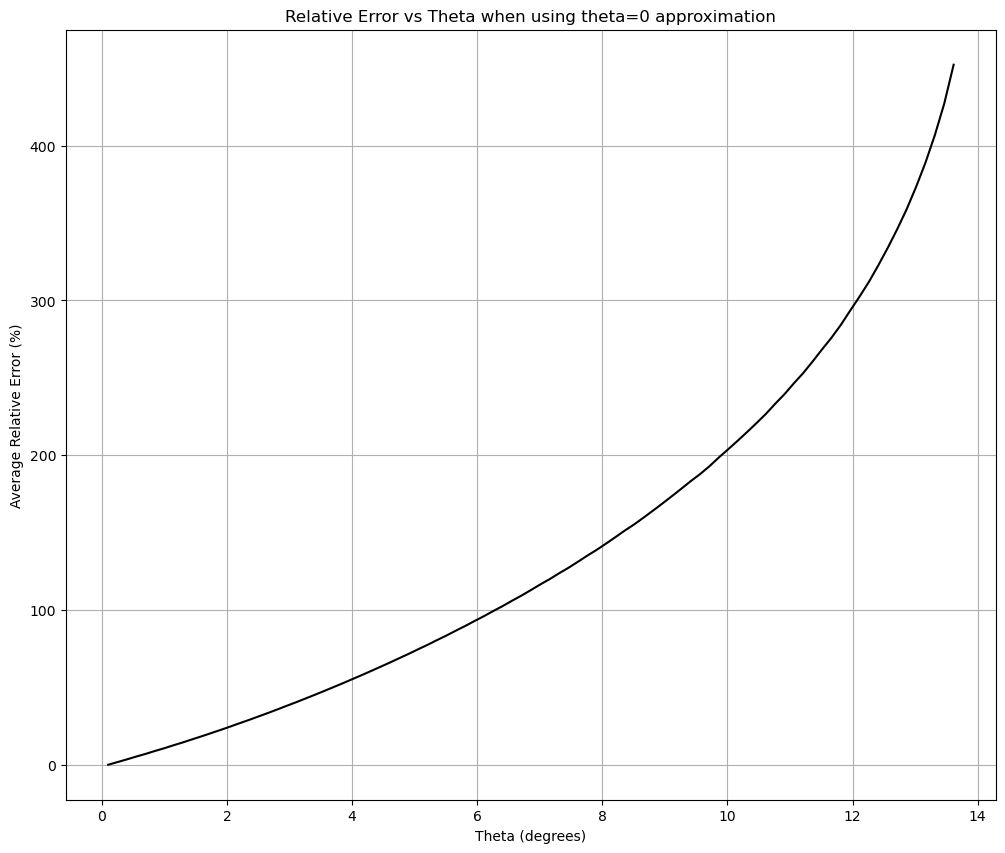

In [23]:
# Get the first column (reference column for theta ≈ 0)
ref_column = weak_beta[:, 0]

# Calculate absolute and relative errors for each column
errors = []
for j in range(weak_beta.shape[1]):
	# Get current theta value
	current_theta = theta_vals[j]
	
	# Get current column
	current_column = weak_beta[:, j]
	
	# Calculate errors only for non-nan values
	mask = ~np.isnan(current_column) & ~np.isnan(ref_column)
	if np.any(mask):
		abs_error = np.mean(np.abs(current_column[mask] - ref_column[mask]))
		rel_error = np.mean(np.abs((current_column[mask] - ref_column[mask])/ref_column[mask])) * 100
		errors.append({
			'theta': current_theta,
			'absolute_error': abs_error,
			'relative_error': rel_error
		})

# Convert to DataFrame for better visualization
error_df = pd.DataFrame(errors)
print("First few rows of error analysis:")
print(error_df.head())

# Plot errors
plt.figure(figsize=(12, 10))
plt.plot(error_df['theta'], error_df['relative_error'], 'k-')  # 'k-' specifies black solid line
plt.xlabel('Theta (degrees)')
plt.ylabel('Average Relative Error (%)')
plt.title('Relative Error vs Theta when using theta=0 approximation')
plt.grid(True)
plt.show()